# NEURAL NETWORKS AND DEEP LEARNING PROJECT

---
A.A. 2023/24 (6 CFU) - Giuseppe Labate, Sana Amiri
---

## Project 1 - Car classification, attribute prediction and car verification

In this project 

1.   **Classification** car images given cars dataset CompCars.

2.   **Attributes prediction** based on the images.  
        Attributes for this project are:  
    1. Explicit Attributes:  
    	1. Number of doors  
    	2. Number of seats  
    	3. Type of car  
	2. Implicit Attributes:  
    	4. Max speed  
    	5. Displacement  


In [17]:
## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
# %matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
# sns.set()  ---> Uncomment if you want to use seaborn themes

## tqdm for loading bars
from tqdm.notebook import tqdm
import os
import random
## NumPy
import numpy as np
## PyTorch
import torch
import torch.nn as nnpo
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision   # For Computer Vision tasks
from torchvision import transforms   # Transforms for images for data augmentation


# Path to the folder where the datasets are/should be downloaded 
DATA_PATH = os.path.join(".", "Deep_Project", "data")  # Change this path to your desired location

NUM_WORKERS = 0 #os.cpu_count()

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

Device: cuda:0
Number of workers: 0


C:\Users\giuse\AppData\Local\Temp\ipykernel_21948\3711533681.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


<Figure size 640x480 with 0 Axes>

In [18]:
# import torchvision.models as models
# from torchvision.models import ResNet50_Weights

# # Carica un modello pre-addestrato su ImageNet
# model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# # Metti il modello in modalità di valutazione
# model.eval()

In the following cell, I will create a transformation composition that will be applied to the images in our dataset. This transformation is crucial for preprocessing the images before they are fed into our machine learning model. The preprocessing steps may include operations such as resizing, normalization, augmentation, and other techniques to enhance the quality and variability of the training data. By applying these transformations, we aim to improve the model's performance and generalization capabilities. Let's proceed with defining this transformation function in the next cell.

In [19]:
transform = transforms.Compose([
	#transforms.Resize((224, 224)),
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In the next code snippet, we will perform DataLoading of the dataset contained in `./Deep_Project/data`. The dataset will be split according to the splitting files located in the `train_test_split` folder.

FROM HERE THE CODE IS USED TO CROP THE DATASET AND LOAD IT CORRECTLY WITH THE RIGHT LABEL


In [20]:
####MODIFICA ALLA FUNZIONE SAVE_CROP_IMAGES###
#HERE THE FUNCTION HAS TO SAVE THE IMAGES IN THE FOLDER CROPPED_IMAGES/DIRECTORY OF THE FULL IMAGE
#FOR EXAMPLE, IF THE FULL IMAGE IS IN THE FOLDER "image/AM General Hummer SUV 2000" THE CROPPED IMAGE HAS TO BE SAVED IN "cropped_images/classification/train/AM General Hummer SUV 2000"
#WE WANT ALSO TO DO IT WITHOUT USING CROPDATASET FUNCTION

from PIL import Image
import torchvision.transforms as transforms

# Path to the folder where the datasets are/should be downloaded
image_dir = os.path.join(DATA_PATH, "image")
label_dir = os.path.join(DATA_PATH, "label")
train_list = os.path.join(DATA_PATH, "train_test_split", "classification", "train.txt")
test_list = os.path.join(DATA_PATH, "train_test_split", "classification", "test.txt")

def crop_image(image, bbox):
	x1, y1, x2, y2 = bbox
	image_np = np.array(image)
	return image_np[y1:y2, x1:x2]

#Loads the viewpoint and bounding box from the label file
def load_label(label_path):
	with open(label_path, 'r') as f:
		lines = f.readlines()
		viewpoint = int(lines[0].strip())
		bbox = list(map(int, lines[2].strip().split()))
	return viewpoint, bbox

def save_cropped_images(file_list, output_dir): 
	# Create the output directory if it does not exist
	if not os.path.exists(output_dir):
		os.makedirs(output_dir)
	
		# Access to the image paths and labels
		with open(file_list, 'r') as f:
			for line in tqdm(f, desc="Saving images"):
				image_path = os.path.join(image_dir, line.strip())
				label_path = os.path.join(label_dir, line.strip()).replace('.jpg', '.txt')
				car_properties = load_label(label_path)
				# Dividing the label path into car make, model and year
				label_path_parts = line.strip().split('/')
            
            	# Given the values of labels path, put the correct car make, model and year in the output directory	
				output_image_dir = os.path.join(output_dir, label_path_parts[0], label_path_parts[1], label_path_parts[2])
				os.makedirs(output_image_dir, exist_ok=True)
				
				# Load the image
				image = Image.open(image_path).convert("RGB")
				
				# Crop the image
				cropped_image = crop_image(image, car_properties[1])
				cropped_image = transforms.ToPILImage()(cropped_image)
				
				# Save the cropped image
				output_image_path = os.path.join(output_image_dir, os.path.basename(image_path))
				cropped_image.save(output_image_path)

# Example usage
output_dir = os.path.join(DATA_PATH, "cropped_image", "classification")
train_path = os.path.join(output_dir, "train")

test_path = os.path.join(output_dir, "test")
print("test", test_path)
print("train", train_path)
save_cropped_images(train_list, train_path)
save_cropped_images(test_list, test_path)


test .\Deep_Project\data\cropped_image\classification\test
train .\Deep_Project\data\cropped_image\classification\train


In [21]:
#### DATA LOADER FOR CROPPED IMAGES ####
from torch.utils.data import Dataset, DataLoader
import scipy.io

class CroppedCarDataset(Dataset):
    def __init__(self, image_dir, mat_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        
		# Save the images contained in image_dir
        self.image_paths = []
        for root, _, files in os.walk(image_dir):
            for file in files:
                if file.endswith(".jpg"):
                    self.image_paths.append(os.path.join(root, file))
        
		# Save the labels
        self.labels = []
        for image_path in self.image_paths:
            label = image_path.split(os.sep)[-4:-1]  # Car make, model, year
            self.labels.append((label[0], label[1], label[2]))
            
		# Load the make and model names from the .mat file
        mat_data = scipy.io.loadmat(mat_file)
        self.make_names = mat_data['make_names']
        self.model_names = mat_data['model_names']

	#Returns the image, viewpoint, bounding box and label path
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert("RGB")
        
		# # Get the make and model names
        labels = self.labels[index]
        make_name = self.make_names[int(labels[0]) - 1][0].item()
        model_name = self.model_names[int(labels[1]) - 1][0].item()
        
        label = (make_name, model_name, labels[2])
        #label = (labels[0], labels[1], labels[2])
        
        
        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.image_paths)

print("Data loading is complete.")



Data loading is complete.


In [22]:
# Path to the folder where the datasets are/should be downloaded
class_dir = os.path.join(DATA_PATH, "cropped_image", "classification")
train_dir = os.path.join(class_dir, "train")
test_dir = os.path.join(class_dir, "test")
mat_file = os.path.join(DATA_PATH, "misc" ,"make_model_name.mat")
# Create the datasets
train_dataset = CroppedCarDataset(image_dir=train_dir, mat_file=mat_file, transform=transform)
test_dataset = CroppedCarDataset(image_dir=test_dir, mat_file=mat_file, transform=transform)

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=NUM_WORKERS)

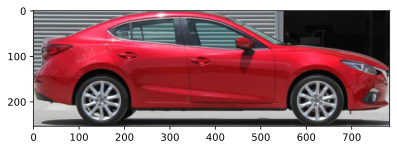

Labels: ('MAZDA', 'Axela sedan', '2014')
Number of images in the training set: 16016
Number of images in the test set: 14939
Image shape: torch.Size([3, 254, 784])


In [64]:
import numpy as np
import matplotlib.pyplot as plt

# Function to denormalize images
def denormalize(img, mean, std):
    img = img.clone()  # Create a copy of the image
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)  # Denormalize
    return img

# Function to display images
def imshow(img):
    #img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Mean and std used for normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Display the first 5 images from the training set
# for i in range(5):
#     img, label = train_dataset[i]
#     img = denormalize(img, mean, std)
#     imshow(img)
#     print("Labels:",label)

img, label = train_dataset[7434]
img = denormalize(img, mean, std)
imshow(img)
print("Labels:",label)


print("Number of images in the training set:", len(train_dataset))
print("Number of images in the test set:", len(test_dataset))
print("Image shape:", img.shape)

In [24]:
####QUESTO è IL CODICE DEL TIZIO CHE HA FATTO LA FUNZIONE CROP_IMAGE


# from multiprocessing import Pool
# from skimage import io

# if not os.path.exists(os.path.join(DATA_PATH, 'cropped_image')):
#     os.mkdir(os.path.join(DATA_PATH, 'cropped_image'))


# def fun(img_path):
#     assert(os.path.exists(os.path.join(DATA_PATH, 'image', img_path)) and
#            os.path.exists(os.path.join(DATA_PATH, 'label', img_path.replace('jpg', 'txt'))))

#     lb_fd = open(os.path.join(DATA_PATH, 'label', img_path.replace('jpg', 'txt')))
#     label = lb_fd.readlines()
#     x1, y1, x2, y2 = map(int, label[-1].split(' '))
#     im = io.imread(os.path.join(DATA_PATH, 'image', img_path))
#     cropped_im = im[y1:y2, x1:x2, :]
#     make, model, year, filename = img_path.replace('jpg', 'txt').split('/')
#     if not os.path.exists(os.path.join(DATA_PATH, 'cropped_image', make, model, year)):
#         try:
#             os.makedirs(os.path.join(DATA_PATH, 'cropped_image', make, model, year))
#         except:
#             pass
#     io.imsave(os.path.join(os.path.join(DATA_PATH, 'cropped_image', img_path)), cropped_im)



# process_num = 2

# img_list_file = [
# #     /data/train_test_split/verification/verification_train.txt',
# #    '../data/train_test_split/verification/verification_list.txt',
#      "./Deep_Project/data/train_test_split/classification/train.txt",    #../data/train_test_split/classification/
# #     '../data/train_test_split/classification/test.txt',
# ]

# for img_list in img_list_file:
# 	with open(img_list, 'r') as f:
# 		img_paths = f.readlines()
# 		img_paths = [x.strip() for x in img_paths]

# 	p = Pool(process_num)
# 	p.map(fun, img_paths)
# 	p.close()
# 	p.join()